In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import numpy as np

import datetime as dt

In [2]:
# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
# px를 쉽고 빠르게 붙여주는 모듈 cufflinksget_rsi
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')

import plotly.graph_objects as go

import matplotlib.pyplot as plt
import seaborn as sns

import math

In [3]:
%run ../library/QUANT_FUNCTIONS.ipynb
Q = QUANT()

In [4]:
## 조건1. 판단기준 -> 1개월*12, 3개월*4, 6개월*2 평균, 12개월*1
## 조건2. 공격자산 중 하나라도 (-)진입시 수비자산 전환
## 조건3. 모든 포지션에서 판단기준값이 가장 높은 자산 투자
## 조건4. 월단위 리벨런싱

###### 공통함수

In [5]:
## 수치형 데이터프레임을 시작점기준으로 지수화
def index_values(orgin_df):
    df = orgin_df.copy()
    for i in df.columns:
        if (df[i].dtype == float)|(df[i].dtype == int):
            df[i] = df[i]/df[i][0]
        else:
            df[i] = df[i]
    return df

## 데이터 불러오기
def get_df(ticker):
    profit = yf.Ticker(ticker)
    df = profit.history(period="max")
    return df

## VAA

### 데이터 구성 함수

In [11]:
def get_merged_df(*tickers):
    dfs = [get_df(tickers[i])[:-1] for i in range(len(tickers))]
    temp_df = [dfs[i]['Close'] for i in range(len(dfs))]
    temp_df = pd.DataFrame(temp_df, index=tickers).T
    return temp_df

### VAA 전략구현

In [12]:
### 1개월 수익률, 3개월 수익률, 6개월 수익률의 가중평균 산출함수
def get_wapr(close):
    ## 월단위 데이터를 기준으로함
    ## get_signal()로 이어짐
    df_cls = close.copy()
    pr1 = np.log(df_cls/df_cls.shift(1))
    pr3 = np.log(df_cls/df_cls.shift(3))
    pr6 = np.log(df_cls/df_cls.shift(6))
    pr12 = np.log(df_cls/df_cls.shift(12))
    df_pr = pd.concat([pr1, pr3*(4/12), pr6*(2/12), pr12*(1/12)], axis = 1)
    mpr = df_pr.mean(axis=1)
    
    return mpr

def get_signal(df):
    ## 금리2% 1개월 무위험수익률 ## 향후 기준금리 데이터 반영 가능
    nrr = (1.02**(1/12))-1
    ## get_strategy_value()로 이어짐

    signal_df = df.copy()
    for cols in signal_df.columns:
        signal_df[cols] = get_wapr(signal_df[cols])
    signal_df = signal_df.dropna()

    atks= signal_df[signal_df.columns[:4]].T
    dfcs= signal_df[signal_df.columns[4:]].T
    
    ## 판단로직
    signal_df['diretion'] = 'bear'
    signal_df['diretion'][(signal_df[signal_df.columns[0]] > nrr)&(signal_df[signal_df.columns[1]] > nrr)&
                       (signal_df[signal_df.columns[2]] > nrr)&(signal_df[signal_df.columns[3]] > nrr)] = 'bull'

    optimal_ticker = []
    for i in range(len(signal_df)):
        if signal_df['diretion'][i] == 'bull':
            optimal_ticker.append(atks[atks[atks.columns[i]] == atks[atks.columns[i]].max()].index.values[0])
        elif signal_df['diretion'][i] == 'bear':
            optimal_ticker.append(dfcs[dfcs[dfcs.columns[i]] == dfcs[dfcs.columns[i]].max()].index.values[0])

    signal_df['signal'] = optimal_ticker
    ### 여기
    
    new_df = df.copy()
    new_df['signal'] = signal_df['signal']
    new_df['prev'] = new_df['signal'].shift(1)
    
    new_df['change'] = 0
    new_df['change'][new_df['signal'] != new_df['prev']] = 1
    new_df = new_df.dropna()
    
    return new_df, signal_df



def get_strategy_value(df):
    new_df, signal_df = get_signal(df)
    
    ## 시그널발생시 자산 교환 비율 산출
    new_df['exchange_rate'] = 1.0
    for i in range(len(new_df)):
        if (new_df['change'][i] == 1)&(type(new_df['prev'][i]) == str):
            new_df['exchange_rate'][i] = new_df[new_df['prev'][i]][i]/new_df[new_df['signal'][i]][i]         
    ## 누적 교환비 산출
    new_df['cum_exchange_rate'] = new_df['exchange_rate']
    for i in range(len(new_df)):
        new_df['cum_exchange_rate'][i] = new_df['exchange_rate'][:i+1].product()
    ## 자산추이
    new_df['strategy'] = 1.0
    for i in range(len(new_df)):
        new_df['strategy'][i] = new_df[new_df['signal'][i]][i]*new_df['cum_exchange_rate'][i]
        
    result = new_df.drop(columns=['change', 'exchange_rate', 'cum_exchange_rate'])
        
    return result

## 활용 예시

In [13]:
## X3 VAA전략 ## 확정전
## df = get_merged_df('TQQQ', 'UPRO', 'EURL', 'EDC', 'TMF', 'TYD', 'BNKU')
## df['CASH'] = 1 ## SHY 대용 CASH
df = get_merged_df('SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY')

dataset = df.dropna()
## dataset = dataset[dataset.index >= '2010-10-01']

In [15]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import coint

In [16]:
dataset.columns

Index(['SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY'], dtype='object')

In [21]:
## 월단위 변환 함수
def day_to_mth(dataset):
    df = dataset.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    ## df = df[df['day']>=24]

    df = df.drop_duplicates(['year', 'month'], keep='last')
    df = df.drop(columns=['year', 'month', 'day'])
    return df

In [22]:
df = day_to_mth(dataset)

In [23]:
df = df[:].copy()

In [24]:
strategy_df_result = get_strategy_value(df)
result_df = index_values(strategy_df_result)

In [25]:
result_df.to_csv('result/VAA_result.csv')

In [26]:
a, signal_df = get_signal(df)

###### 보고서

In [27]:
np.log(strategy_df_result[strategy_df_result.columns[:-3]]/strategy_df_result[strategy_df_result.columns[:-3]].shift(1)).tail(5)

,SPY,QQQ,VEA,VWO,TLT,IEF,SHY
Date,,,,,,,
2021-11-30,-0.008067,0.019772,-0.047544,-0.029446,0.027338,0.010862,-0.000571
2021-12-31,0.045210,0.011457,0.042375,0.015285,-0.020343,-0.005254,-0.002125
2022-01-31,-0.054183,-0.091535,-0.039346,0.004237,-0.039925,-0.021357,-0.006921
2022-02-28,-0.029961,-0.045792,-0.026839,-0.037957,-0.016465,-0.003046,-0.004331
2022-03-11,-0.038665,-0.066771,-0.056826,-0.086441,-0.034782,-0.013110,-0.004327


In [28]:
strategy_df_result.tail(12)

,SPY,QQQ,VEA,VWO,TLT,IEF,SHY,signal,prev,strategy
Date,,,,,,,,,,
2021-04-30,413.159424,336.794312,49.248314,51.709209,136.672379,113.050415,86.078827,SPY,SPY,325.541595
2021-05-28,415.872223,332.748688,51.009617,52.587616,136.675308,113.530754,86.130699,VEA,SPY,327.679096
2021-06-30,425.199188,353.585846,50.539635,53.285351,142.715118,114.691673,85.983009,QQQ,VEA,324.659993
2021-07-30,435.579346,363.701721,50.794689,50.145721,148.019379,116.974304,86.125732,TLT,QQQ,333.948317
2021-08-31,448.542145,379.045135,51.461746,51.244591,147.515854,116.512909,86.097778,QQQ,TLT,332.812309
2021-09-30,427.637634,357.503387,49.719479,49.521748,143.227570,114.652138,86.010925,SHY,QQQ,313.898047
2021-10-29,457.642181,385.617462,51.324600,50.165401,146.758133,114.144279,85.722351,QQQ,SHY,312.844891
2021-11-30,453.965118,393.317657,48.941532,48.709755,150.825516,115.390869,85.673424,TLT,QQQ,319.091929
2021-12-31,474.959991,397.850006,51.060001,49.459999,147.788208,114.786179,85.491562,SHY,TLT,312.666090


In [31]:
signal_df.tail(5)

,SPY,QQQ,VEA,VWO,TLT,IEF,SHY,diretion,signal
Date,,,,,,,,,
2021-11-30,0.007714,0.020798,-0.015238,-0.013625,0.011974,0.001941,-0.000873,bear,TLT
2021-12-31,0.029921,0.021738,0.015536,0.000874,-0.001999,-0.001887,-0.001424,bear,SHY
2022-01-31,-0.009271,-0.024897,-0.013339,-0.000459,-0.015496,-0.009250,-0.003427,bear,SHY
2022-02-28,-0.008706,-0.023481,-0.011209,-0.015316,-0.012938,-0.005358,-0.003337,bear,SHY
2022-03-11,-0.019225,-0.037334,-0.029658,-0.039743,-0.018543,-0.008174,-0.003737,bear,SHY


In [32]:
test_dfs = [result_df.reset_index().shift(i).set_index('Date')[-(len(result_df)+1 - int(len(result_df)/10)):]
            for i in range(int(len(result_df)/10))]

In [33]:
CAGR = np.mean([Q.get_ACI_CAGR(test_dfs[i]['strategy']) for i in range(len(test_dfs))])
print(f'전략의 적립식 투자 수익률은 {CAGR.round(2)}%')

전략의 적립식 투자 수익률은 147.16%


In [34]:
RPP = np.mean([ Q.get_ACI_RPP(test_dfs[i]['strategy']) for i in range(len(test_dfs))])
print(f'전략의 단위수익률은 {RPP.round(2)}%')

전략의 단위수익률은 1.14%


In [35]:
result_df = result_df.tail(60)
## 연수익률
Q.get_YTD_report(result_df, 'a')

,SPY,QQQ,VEA,VWO,TLT,IEF,SHY,strategy
Date,,,,,,,,
2018,-0.045690,-0.001262,-0.147453,-0.147605,-0.016119,0.009878,0.014632,0.111929
2019,0.312239,0.389616,0.226211,0.207502,0.141184,0.080295,0.033807,0.176539
2020,0.183316,0.484061,0.097138,0.151756,0.181522,0.100067,0.030341,0.228842
2021,0.287288,0.274197,0.116641,0.012589,-0.045991,-0.033278,-0.007156,0.051772
MEAN,0.175221,0.272796,0.063811,0.046720,0.060653,0.037846,0.017777,0.140316


In [36]:
## 전고점대비 최대낙폭(MDD)
MDD, HRR = Q.get_MDD_report(result_df, 'a')
MDD

,Ticker,MDD,Date
0,SPY,-0.194477,2020-03-31
1,QQQ,-0.184617,2022-03-11
2,VEA,-0.241427,2020-03-31
3,VWO,-0.283372,2020-03-31
4,TLT,-0.200915,2021-03-31
5,IEF,-0.086749,2022-03-11
6,SHY,-0.022764,2022-03-11
7,strategy,-0.086476,2020-10-30


In [37]:
## sortino ratio
sort_df = Q.get_SRTR_report(test_dfs[0], 'a', unit='monthly')
sort_df['YRR'] = np.mean([Q.get_SRTR_report(test_dfs[i], 'a', unit='monthly')['YRR'] for i in range(len(test_dfs))], axis=0)
sort_df['YDD'] = np.mean([Q.get_SRTR_report(test_dfs[i], 'a', unit='monthly')['YDD'] for i in range(len(test_dfs))], axis=0)
sort_df['Sortino Ratio'] = np.mean([Q.get_SRTR_report(test_dfs[i], 'a', unit='monthly')['Sortino Ratio'] for i in range(len(test_dfs))], axis=0)

In [38]:
sort_df

,Ticker,YRR,YDD,Sortino Ratio
0,SPY,0.118808,0.101212,1.195750
1,QQQ,0.182691,0.104988,1.780924
2,VEA,0.048130,0.126675,0.393837
3,VWO,0.044344,0.145356,0.325358
4,TLT,0.062010,0.079710,0.778812
5,IEF,0.042261,0.034771,1.216639
6,SHY,0.013553,0.004503,3.022095
7,strategy,0.129433,0.073445,1.769049


In [29]:
result_df['signal'].value_counts()

QQQ    17
TLT    16
SHY    10
VWO     8
VEA     4
SPY     4
IEF     1
Name: signal, dtype: int64

In [30]:
## ticker별 단위수익률

In [31]:
def get_ticker_return(result_df, ticker):
    call = result_df[(result_df['signal'] == ticker)]
    put = result_df[(result_df['prev'] == ticker)]
    if put.index[0] < call.index[0]:
        put = put[1:]    
    if len(call) > len (put):
        call = call[:-1]

    call.index = put.index
    ticker_return = (put['strategy']/call['strategy']).product()
    return ticker_return

In [33]:
'''tickers_vc = result_df['signal'].value_counts()
for i in range(len(tickers_vc.index)):
    print('Ticker :', tickers_vc.index[i],
          '| 개별수익률 :', get_ticker_return(result_df, tickers_vc.index[i]).round(3),
          '| 보유기간 :', tickers_vc.values[i],
          '| 기간수익률 :', ((get_ticker_return(result_df, tickers_vc.index[i])-1)/tickers_vc.values[i]).round(3))'''

"tickers_vc = result_df['signal'].value_counts()\nfor i in range(len(tickers_vc.index)):\n    print('Ticker :', tickers_vc.index[i],\n          '| 개별수익률 :', get_ticker_return(result_df, tickers_vc.index[i]).round(3),\n          '| 보유기간 :', tickers_vc.values[i],\n          '| 기간수익률 :', ((get_ticker_return(result_df, tickers_vc.index[i])-1)/tickers_vc.values[i]).round(3))"

In [34]:
## 시기별 보유자산과 수익률

In [35]:
test = result_df.copy()

In [36]:
for ticker in test['signal'].unique():
    test[ticker+'_sign'] = 0
    test[ticker+'_sign'][test['signal'] == ticker] = 1

In [37]:
test.columns

Index(['SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'signal', 'prev',
       'strategy', 'QQQ_sign', 'VEA_sign', 'VWO_sign', 'SPY_sign', 'SHY_sign',
       'TLT_sign', 'IEF_sign'],
      dtype='object')

In [38]:
test.iplot()

In [126]:
tt = test.tail(12)

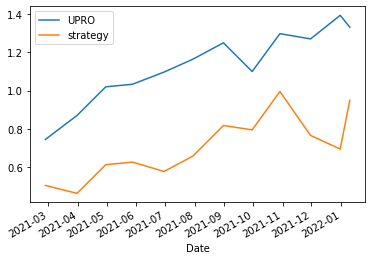

In [127]:
np.log(tt[[tt.columns[1], 'strategy']]).plot()
plt.show()

## 무지성 전략

### 함수정의

In [32]:
def get_INDI(df, seed, duration = 120, sts = 0):
    '''
    df: 종가데이터
    sts: 초기투자금
    seed: 월납입액
    '''
    tickers = list(df.columns)
    df = df.dropna()
    df = day_to_mth(df)
    df = df.tail(duration)

    for ticker in tickers:
        df[f"{ticker}_quant"] = (float(seed)/df[ticker]).apply(lambda x:math.floor(x))
        df[f"{ticker}_cost"] = df[ticker] * df[f"{ticker}_quant"]

        df[f"{ticker}_cquant"] = df[f"{ticker}_quant"].cumsum()
        df[f"{ticker}_cquant"] = df[f"{ticker}_cquant"] + math.floor(sts/df[ticker][0])
        ## df[f"{ticker}_ccost"] = df[f"{ticker}_cost"].cumsum()
        df[ticker] = df[ticker] * df[f"{ticker}_cquant"]

    df = df[tickers]
    df['seed'] = seed
    df['seed'] = df['seed'].cumsum() + sts
    return df

In [38]:
## 원천데이터 불러옴
df_ori = get_merged_df('TQQQ')

In [39]:
df_indi = get_INDI(df_ori[:-10], 1100, 12*14, 82000)

In [35]:
df_indi.iplot()

## 자기상관 테스트

In [165]:
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts
    
from scipy.integrate import quad
from scipy.optimize import root

In [166]:
Ticker = 'LCID'

In [167]:
df_ori = get_merged_df(Ticker)
df_rets = np.log(df_ori/df_ori.shift(1)).dropna()

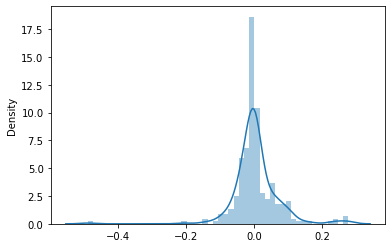

In [168]:
sns.distplot(df_rets)

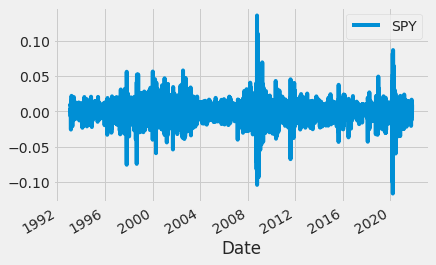

In [3143]:
df_rets.plot()

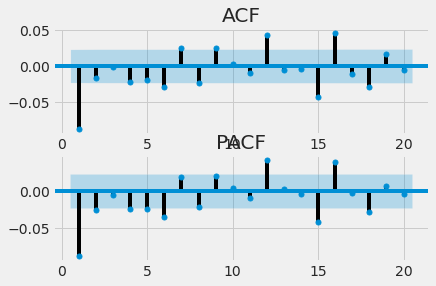

In [3144]:
## Close
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
sgt.plot_acf(df_rets[Ticker], lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF")


sgt.plot_pacf(df_rets[Ticker], lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF")
plt.show()

In [3145]:
sts.adfuller(df_rets[Ticker])

(-15.66308719744073,
 1.545337911078876e-28,
 33,
 7207,
 {'1%': -3.4312576773489325,
  '5%': -2.861941122277684,
  '10%': -2.566983513217699},
 -43590.245578723996)

## MDD CASH 전략

In [54]:
## MDD - HRR 만큼 현금은 보유하는 전략
def get_MDD_CASH_df(df, cash_d=1, sts = 10000):
    '''
    df: ticker 가격정보 시계열
    cash_d: 최대현금비중;(HRR-MDD) 중 실적용 비율
    sts: 투입자금
    '''
    ticker = df.columns[0]
    temp = day_to_mth(df)

    temp['HRR'] = Q.cal_HRR(df, ticker, 'a')['HRR']
    temp['MDD'] = [temp['HRR'].loc[:i].min() for i in temp.index]
    temp['CR'] = (temp['HRR'] - temp['MDD'])/cash_d

    seed = sts*(1-temp['CR'][0])
    cnt = math.floor(seed/temp[ticker][0])
    val = temp[ticker][0]*cnt
    cash = sts - val

    ls = [sts, seed, cnt, val, cash]

    val_ls = []
    val_ls.append(ls)
    for i in range(1, len(temp)):
        sts = temp[ticker][i]*ls[2] + ls[4]
        seed = sts*(1-temp['CR'][i])
        cnt = math.floor(seed/temp[ticker][i])
        val = temp[ticker][i]*cnt
        cash = sts - val

        ls = [sts, seed, cnt, val, cash]
        val_ls.append(ls)

    val_df = pd.DataFrame(val_ls, columns=['sts', 'seed', 'cnt', 'val', 'cash'])
    val_df.index = temp.index

    result = pd.concat([temp, val_df], axis =1)
    
    return result

In [55]:
## 최적 MDD 찾기
df = strategy_df_result[['strategy']]
df = get_merged_df('IAU')
ls = []
for i in range(1, 11):
    print(i)
    result = get_MDD_CASH_df(df, cash_d=i, sts=10000)
    target = result['sts'].pct_change(1).mean()/result['sts'].pct_change(1).std()
    basis = result[df.columns[0]].pct_change(1).mean()/result[df.columns[0]].pct_change(1).std()
    ls.append([i, target, basis, target-basis])

1
2
3
4
5
6
7
8
9
10


In [57]:
## sharpe ratio Gap 커브
pd.DataFrame(ls)[3].iplot()

In [58]:
result = get_MDD_CASH_df(df, cash_d=1)

In [59]:
result[['sts', 'IAU']].pct_change(1).iplot('bar')

In [60]:
## 결론 => 현금들고갈꺼면 차라리 올웨더처럼 자산배분을 해라

## 기술적분석

In [61]:
def take_min_max(ls):
    M = ls.max()
    m = ls.min()
    mmx_ls = (ls-m)/(M-m)    
    return mmx_ls

## 증감량 산출 함수
def get_diff(df=df):
    df_diff = (df - df.shift(1))
    return df_diff

## 증감율 산출 함수
def get_rid(df=df):
    df_diff = get_diff(df=df)
    rid_df = df_diff/df
    return rid_df

## 이동평균 도출 함수
def get_mav(df=df, t=5):
    ave_df = pd.DataFrame(columns=df.columns+'_mav', index=df.index)
    for j in range(len(df.columns)):
        temp = df[df.columns[j]].rolling(t).mean()
        ave_df[ave_df.columns[j]] = temp
    return ave_df

# 빈도로 상대적강도지수를 산출하는 함수
def get_rsi(df=df, t=14):
    temp_df = get_diff(df)
    rsi_df = pd.DataFrame(columns=temp_df.columns, index=temp_df.index)
    for j in range(len(temp_df.columns)):

        rsi_ls = []
        for i in range(1, len(temp_df)+1):
            temp = temp_df[temp_df.columns[j]][i-t:i]
            pi = ((temp + abs(temp))/2).mean()
            nd = abs(((temp - abs(temp))/2).mean())
            if nd == 0:
                rs = np.inf
            else:
                rs = pi/nd

            rsi = 100 - 100/(1+rs)

            rsi_ls.append(rsi)
        rsi_df[rsi_df.columns[j]] = rsi_ls
    return rsi_df

# 빈도로 진동자를 산출하는 함수
def get_pfo(df, t1=5, t2=30):
    st_mav = get_mav(df, t=t1)
    lt_mav = get_mav(df, t=t2)
    pfo = ((st_mav - lt_mav)/lt_mav)*100
    # 컬럼명 '_mav' 제거
    temp_ls = []
    for i in range(len(pfo.columns)):
        temp_nm = pfo.columns[i].split('_')[0]
        temp_ls.append(temp_nm)
    pfo.columns = temp_ls    
    return pfo

## 변동계수 산출 함수
def get_cv(df=df, t=15):
    cv_df = pd.DataFrame(columns=df.columns, index=df.index)
    for j in range(len(df.columns)):
        cv_ls = []
        for i in range(1, len(df)+1):
            temp_mean = df[df.columns[j]][i-t:i].mean()
            temp_std = df[df.columns[j]][i-t:i].std()
            if temp_mean == 0:
                temp = np.inf
            else:
                temp = temp_std/temp_mean
            cv_ls.append(temp)
        cv_df[cv_df.columns[j]] = cv_ls
    return cv_df

In [62]:
tt = get_merged_df('069260.KS')
rsi = get_rsi(tt)
ma = get_mav(tt)

tt['MA'] = ma[ma.columns[0]]
tt['RSI'] = rsi[rsi.columns[0]]

## 기타

In [1056]:
## 수익률 예상

In [1057]:
## AWP 전략
PR = Q.TR_to_PR(12, 1.25) ## 단위(월)수익률
YR = PR**12 ## 연환산 수익률 ## 일반적(이론적) 수익률
YTR = Q.YR_to_TR(12, YR) ## 정기납입 수익률 ## 체감적 수익률

In [1058]:
## VAA 전략
PR = Q.TR_to_PR(3, 1.06) ## 단위(월)수익률
YR = PR**12 ## 연환산 수익률 ## 일반적(이론적) 수익률
YTR = Q.YR_to_TR(12, YR) ## 정기납입 수익률 ## 체감적 수익률

In [7]:
duration = 240 ## 투자기간
a = 200 ## 월납입금
a_sum = a * duration ## 총투자원금
r = 1.10## 연수익률

rst = a_sum * Q.YR_to_TR(duration, r)

In [16]:
((14*0.03)/12)*10000

349.99999999999994

In [12]:
4*(1.05**20)

10.613190820577689

In [1060]:
duration = 7*12 ## 투자기간
a = 170 ## 월납입금
a_sum = a * duration ## 총투자원금
r = 1.40## 연수익률

rst = a_sum * Q.YR_to_TR(duration, r)

In [1061]:
duration = 24 ## 투자기간
a = 120 ## 월납입금
a_sum = a * duration ## 총투자원금
r = 1.35## 연수익률

rst = a_sum * Q.YR_to_TR(duration, r)

## 테스트

In [1062]:
test = get_merged_df('UPRO', 'DRN')
test = test.dropna()

test_rets = np.log(test/test.shift(1))
test_rets = test_rets.dropna()

In [222]:
test_rets.corr()

,UPRO,DRN
UPRO,1.000000,0.752658
DRN,0.752658,1.000000


In [223]:
test_rets['UPRO'].std()

0.03283392546312584

In [224]:
test_rets['DRN'].std()

0.04100799746905769

In [225]:
fig = px.scatter(test_rets, x="UPRO", y="DRN")
fig.show()

In [172]:
def cal_AWP(df, ratio = [0.5, 0.5], rebalancing=None, unit = None):
    new_df = df.copy()
    ## rebalancing 'm'월, 'y'연, 
    df_dict = []
    ## 데이터 분할
    years = sorted(new_df.index.year.unique())
    months = sorted(new_df.index.month.unique())
    
    ## 가치변화 계산용(월단위 집계데이터로 계산할 때 발생하는 에러보정)
    if (rebalancing == 'm')&(unit == 'monthly'):
        temp_df = new_df.copy()
        temp_df.index = temp_df.index - dt.timedelta(days=1)
        new_df = new_df.append(temp_df)
        new_df = new_df.sort_index()
        new_df = new_df.shift(-1).dropna()
        
    if rebalancing == 'm' :
        for year in years:
            for month in months:
                temp = new_df[(new_df.index.year == year)&(new_df.index.month == month)]
                if len(temp) > 0:
                    df_dict.append(temp)
                    
    elif rebalancing == 'y':
        for year in years:
            temp = new_df[(new_df.index.year == year)]
            if len(temp) > 0:
                df_dict.append(temp)
    else:
        df_dict.append(new_df)
    ## 리벨런싱 적용
    prev_val = 1
    temp_series = pd.Series()
    for i in range(len(df_dict)):    
        temp = index_values(df_dict[i])
        temp_AWP = (temp * ratio).sum(axis=1)*prev_val
        prev_val = temp_AWP[-1]
        temp_series = temp_series.append(temp_AWP)
    new_df['strategy'] = temp_series
    
    ## 가치변화 계산용 임시 데이터프레임을 원래 형태로 되돌림
    if (rebalancing == 'm')&(unit == 'monthly'):
        new_df['temp_y'] = new_df.index.year
        new_df['temp_m'] = new_df.index.month
        new_df = new_df.drop_duplicates(['temp_y', 'temp_m'])
        new_df = new_df.drop(columns=['temp_y', 'temp_m'])
        new_df.index = df.index
    
    return new_df

In [579]:
def cal_optimal(df, df_unit='monthly', rebalancing = 'm'):
    ## df_unit 데이터 집계주기 : daily, monthly => 수익, 위험 연율화 계산에 사용
    ## rebalancing 리벨런싱 주기 : None, m, y
    pyrr = []     # 리스트 형태로 수익을 쌓을 장소
    pydd = []     # 리스트 형태로 위험(표준편차)을 쌓을 장소
    pstn = []
    weghs = []

    for p in range (1000):
        if p%25 == 0:
            print(f"{p}단계 진행중")
        weights = np.random.random(len(df.T))   # 랜덤한 n개의 숫자를 생성함(n개의 자산에 대응)
        weights /= np.sum(weights)     # n개의 숫자의 합계가 1이 되도록 조정함(각 자산의 비중)

        result_df = cal_AWP(df, weights, rebalancing=rebalancing, unit=df_unit)
        sortino = Q.get_SRTR_report(result_df, 'a', unit=df_unit)

        pyrr.append(sortino['YRR'][len(sortino)-1])
        pydd.append(sortino['YDD'][len(sortino)-1])
        pstn.append(sortino['Sortino Ratio'][len(sortino)-1])
        weghs.append(weights)

    pyrr = np.array(pyrr)
    pydd = np.array(pydd)
    pstn = np.array(pstn)
    weghs = np.array(weghs)

    process = pd.DataFrame(weghs, columns=df.columns)
    process['YRR'] = pyrr
    process['YDD'] = pydd
    process['Sortino Ratio'] = pstn
    
    obtimal = process[process['Sortino Ratio']==process['Sortino Ratio'].max()]
    obtimal = obtimal.reset_index(drop=True)
    min_risk = process[process['YDD']==process['YDD'].min()]
    min_risk = min_risk.reset_index(drop=True)

    return process, obtimal, min_risk

In [584]:
process, obtimal, min_risk = cal_optimal(test, df_unit='daily', rebalancing = None)

0단계 진행중
25단계 진행중
50단계 진행중
75단계 진행중
100단계 진행중
125단계 진행중
150단계 진행중
175단계 진행중
200단계 진행중
225단계 진행중
250단계 진행중
275단계 진행중
300단계 진행중
325단계 진행중
350단계 진행중
375단계 진행중
400단계 진행중
425단계 진행중
450단계 진행중
475단계 진행중
500단계 진행중
525단계 진행중
550단계 진행중
575단계 진행중
600단계 진행중
625단계 진행중
650단계 진행중
675단계 진행중
700단계 진행중
725단계 진행중
750단계 진행중
775단계 진행중
800단계 진행중
825단계 진행중
850단계 진행중
875단계 진행중
900단계 진행중
925단계 진행중
950단계 진행중
975단계 진행중


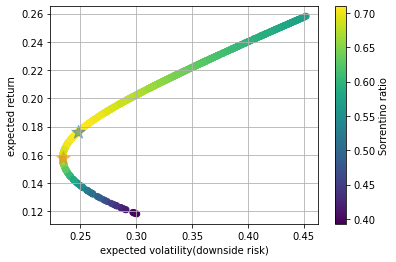

In [764]:
plt.scatter(process['YDD'], process['YRR'], c=process['Sortino Ratio'], marker='o')
plt.grid(True)
plt.xlabel('expected volatility(downside risk)')
plt.ylabel('expected return')
plt.colorbar(label='Sorrentino ratio')

plt.scatter(obtimal['YDD'][0], obtimal['YRR'][0], marker="*", s=200, alpha=0.5)
plt.scatter(min_risk['YDD'][0], min_risk['YRR'][0], marker="*", s=200, alpha=0.5)

plt.show()

In [765]:
obtimal

,TMF,DRN,YRR,YDD,Sortino Ratio
0,0.732591,0.267409,0.176193,0.248257,0.709719


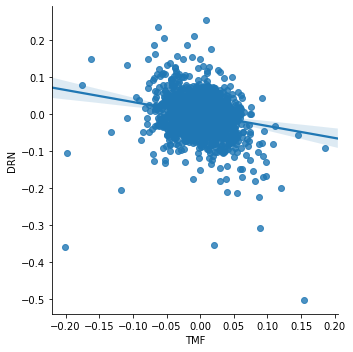

Corr: -0.22, Beta: -0.32


In [766]:
## 자산관계(corr, bata)

## 변동량 데이터구성
rets_origin = Q.get_rets_df(test)
## 상관계수
corr = rets_origin.corr()
corr = np.array(corr)[0, 1]
## 배타산출
beta = Q.cal_beta(rets_origin, "TMF", "DRN")

sns.lmplot(data = rets_origin, x='TMF', y='DRN')
plt.show()
print(f"Corr: {corr.round(2)}, Beta: {beta.round(2)}")

In [629]:
tt = index_values(test)

In [632]:
cal_AWP(tt, ratio=[0.5, 0.5])

,TMF,DRN,strategy
Date,,,
2009-07-16,1.000000,1.000000,1.000000
2009-07-17,0.955939,0.924166,0.940053
2009-07-20,0.968050,0.995443,0.981746
2009-07-21,1.033754,1.002766,1.018260
2009-07-22,1.001804,1.011066,1.006435
...,...,...,...
2021-07-19,4.084367,15.038964,9.561665
2021-07-20,3.969465,16.127576,10.048520
2021-07-21,3.817153,16.141016,9.979084


In [622]:
test_rets[test_rets['DRN'] < -.3]

,TMF,DRN
Date,,
2011-08-08,0.089349,-0.308039
2020-03-12,0.020572,-0.351993
2020-03-16,0.154963,-0.500987
2020-03-18,-0.200169,-0.357785


In [623]:
test.iplot()

In [252]:
dataset.head(5)

,TQQQ,UPRO,VEA,VWO,TMF,TYD,SHY
Date,,,,,,,
2010-10-01,1.132164,4.198729,24.881750,34.639111,10.823065,24.338385,76.938522
2010-10-04,1.092887,4.106993,24.553888,34.609100,10.915778,24.598255,76.947639
2010-10-05,1.174246,4.350448,25.230993,35.119267,10.725935,24.598255,76.984116
2010-10-06,1.144321,4.353434,25.416306,35.186794,11.123278,25.040033,76.993233
2010-10-07,1.155543,4.336064,25.373541,34.849171,10.853970,25.136555,77.057091


In [10]:
import statsmodels.api as sm

In [45]:
model = sm.tsa.DynamicFactorMQ(dataset)

/root/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [46]:
results = model.fit(disp=10)

EM start iterations, llf=27548
EM iteration 10, llf=30181, convergence criterion=2.8603e-05
EM iteration 20, llf=30190, convergence criterion=3.0424e-05
EM iteration 30, llf=30198, convergence criterion=1.7267e-05
EM iteration 40, llf=30201, convergence criterion=7.1702e-06
EM iteration 50, llf=30203, convergence criterion=5.634e-06
EM iteration 60, llf=30204, convergence criterion=5.8078e-06
EM iteration 70, llf=30206, convergence criterion=6.1114e-06
EM iteration 80, llf=30208, convergence criterion=6.3703e-06
EM iteration 90, llf=30210, convergence criterion=6.5342e-06
EM iteration 100, llf=30212, convergence criterion=6.5762e-06
EM iteration 110, llf=30214, convergence criterion=6.4723e-06
EM iteration 120, llf=30216, convergence criterion=6.2282e-06
EM iteration 130, llf=30218, convergence criterion=5.8728e-06
EM iteration 140, llf=30220, convergence criterion=5.4517e-06
EM iteration 150, llf=30221, convergence criterion=5.018e-06
EM iteration 160, llf=30223, convergence criterion

In [47]:
results.summary()

Dep. Variable:,"""TQQQ"", and 6 more",No. Observations:,2724
Model:,Dynamic Factor Model,Log Likelihood,30238.111
,+ 1 factors in 1 blocks,AIC,-60430.223
,+ AR(1) idiosyncratic,BIC,-60294.296
Date:,"Thu, 29 Jul 2021",HQIC,-60381.090
Time:,08:23:46,EM Iterations,301
Sample:,0,,
,- 2724,,
Covariance Type:,Not computed,,
Factor loadings:,0,idiosyncratic: AR(1),var.
TQQQ,-0.40,1.00,0.00


In [56]:
from scipy.stats import norm

mean = results.factors.smoothed
std = results.factors.smoothed_cov
std.index = mean.index
crit = norm.ppf(1 - 0.05 / 2)

/root/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:2922: ValueWarning:

No supported index is available. The `states` DataFrame uses a generated integer index

/root/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:2922: ValueWarning:

No supported index is available. The `states` DataFrame uses a generated integer index

/root/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:2922: ValueWarning:

No supported index is available. The `states` DataFrame uses a generated integer index

/root/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:2922: ValueWarning:

No supported index is available. The `states` DataFrame uses a generated integer index

/root/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:2922: ValueWarning:

No supported index is available. The `states` DataFrame uses a generated integer index

/root/anaconda3/lib/python3.7/site-packa

In [57]:
lower = mean - crit * std
upper = mean + crit * std

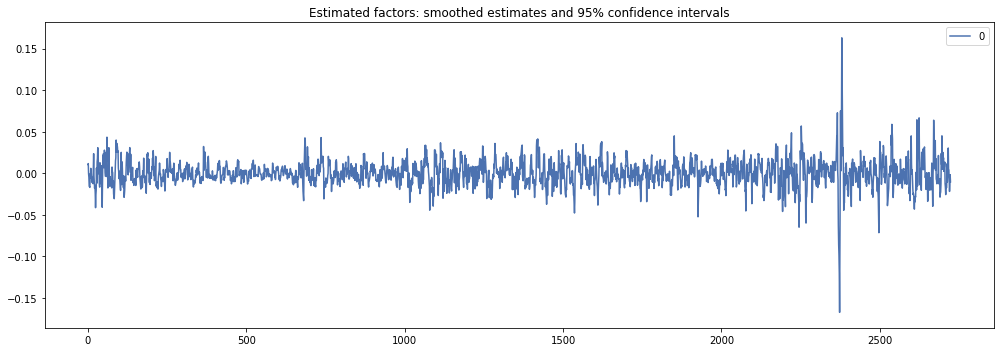

In [64]:
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 5))
    mean.plot(ax=ax)
    
    ax.fill_between(mean.index, lower['0'], upper['0'], alpha=0.1)
    
    ax.set(title='Estimated factors: smoothed estimates and 95% confidence intervals')
    fig.tight_layout()